## Sentiment Analysis of Amazon Review Data

In [23]:
import json
import pandas as pd
import re
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2, SelectPercentile, f_classif
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

#Unterdrückung von Update Hinweisen
import warnings
warnings.filterwarnings('ignore')

In [24]:
with open('config.json') as json_data_file:
    config = json.load(json_data_file)

In [25]:
data = pd.read_csv("./Data_filtered/reviews_Automotive.csv", sep=";")
data.head(5)

,review,rating,products
0,"['needed', 'set', 'jumper', 'cables', 'new', '...",5.0,B00KIAQ8VW
1,"['long', 'cables', 'work', 'fine', 'truck', 'q...",4.0,B00KIAQ8VW
2,"['comment', 'much', 'since', 'yet', 'used', 'c...",5.0,B00KIAQ8VW
3,"['absolutley', 'love', 'amazon', 'price', 'set...",5.0,B00KIAQ8VW
4,"['purchased', 'twelve', 'feet', 'long', 'cable...",5.0,B00KIAQ8VW


In [26]:
# 1, 2, 3 = negativ 4, 5 = positiv
data["label"] = pd.cut(data["rating"], bins = config["label_two"]["bins"], labels = config["label_two"]["labels"])
data["label"] = data["label"].astype(str)
data.head(5)

,review,rating,products,label
0,"['needed', 'set', 'jumper', 'cables', 'new', '...",5.0,B00KIAQ8VW,positiv
1,"['long', 'cables', 'work', 'fine', 'truck', 'q...",4.0,B00KIAQ8VW,positiv
2,"['comment', 'much', 'since', 'yet', 'used', 'c...",5.0,B00KIAQ8VW,positiv
3,"['absolutley', 'love', 'amazon', 'price', 'set...",5.0,B00KIAQ8VW,positiv
4,"['purchased', 'twelve', 'feet', 'long', 'cable...",5.0,B00KIAQ8VW,positiv


In [51]:
#Build an evenly distribued dataframe
positiv = data[data['label'] =='positiv']
negativ = data[data['label'] =='negativ']

positiv_sample = positiv.sample(n=negativ.label.count(), replace=False, random_state=42)

#Merge postiv und negativ dataframe
balanced_dataset = pd.concat([negativ, positiv_sample])
data = balanced_dataset
data.label.count()

5156

In [76]:
X_train, X_test, y_train, y_test = train_test_split(data['review'], data['label'], test_size=0.2, random_state=42, stratify=data['label'])

#Vectorizer
vect = CountVectorizer(stop_words="english")
#vect = TfidfVectorizer()

#feature selection
f_select = SelectKBest(f_classif, k=10000)
#f_select = SelectPercentile(f_classif, percentile=20)

from sklearn.ensemble import RandomForestClassifier

#Classifier
clf = MultinomialNB(alpha=1.0, class_prior=[0.5, 0.5], fit_prior=False)
#clf = LinearSVC(C=1.0, penalty= "l1", max_iter=3000, dual=False)
#clf = RandomForestClassifier(n_estimators=1000, max_depth=2, random_state=42)
#clf = LogisticRegression(random_state=42, class_weight=None, max_iter=3000)



#Building the Pipeline
pipeline = Pipeline([('vect', vect),
                     ('f_select', f_select), 
                     ('clf', clf)])

In [77]:
from sklearn import metrics
model = pipeline.fit(X_train, y_train)

#Results step of Pipeline
vectorizer = model.named_steps['vect']
feature_selection = model.named_steps['f_select']
classifier = model.named_steps['clf']


#Accuracy score of Train Data
print("accuracy score: " + str(model.score(X_train, y_train)))

accuracy score: 0.8959747817652765


In [78]:
from sklearn.metrics import accuracy_score
model = pipeline.fit(X_train, y_train)

#Accuracy Score of Model prediction 
print("accuracy score: " + str(model.score(X_test, y_test)))

#Report on prediction of model
predictions = model.predict(X_test)
print("Classificaton Report:")
print(metrics.classification_report(y_true=y_test, y_pred=predictions))

accuracy score: 0.7189922480620154
Classificaton Report:
              precision    recall  f1-score   support

     negativ       0.70      0.76      0.73       516
     positiv       0.74      0.67      0.71       516

   micro avg       0.72      0.72      0.72      1032
   macro avg       0.72      0.72      0.72      1032
weighted avg       0.72      0.72      0.72      1032



In [88]:
"""
feature_names = vectorizer.get_feature_names()
feature_names = [feature_names[i] for i in feature_selection.get_support(indices=True)]
feature_names = np.asarray(feature_names)

target_names = ['Negativ', 'Positv']
print("top 10 keywords per class:")
for i, label in enumerate(target_names):
    top10 = np.argsort(classifier.coef_[0])[-10:]
print("%s: %s" % (label, " ".join(feature_names[top10])))

classifier.coef_'
"""

'\nfeature_names = vectorizer.get_feature_names()\nfeature_names = [feature_names[i] for i in feature_selection.get_support(indices=True)]\nfeature_names = np.asarray(feature_names)\n\ntarget_names = [\'Negativ\', \'Positv\']\nprint("top 10 keywords per class:")\nfor i, label in enumerate(target_names):\n    top10 = np.argsort(classifier.coef_[0])[-10:]\nprint("%s: %s" % (label, " ".join(feature_names[top10])))\n\nclassifier.coef_\'\n'

In [85]:
#Test with Manual review Text
print(model.predict(["the bad"]))
print(model.predict(['My order broke and I am very disappointed']))
print(model.predict(['My order works perfect and and I am very glad I bought it']))

['negativ']
['negativ']
['positiv']


In [86]:
#Test mit LIDL Reviews
print(model.predict(['I found it a bit too rich. But heated up with some cream it is the most amazing taste']))
print(model.predict(['Nice, but too sweet for me. Would prefer the icing to be more bitter. It would then complement the rich cake']))
print(model.predict(['Very rich but moreish. The chocolate is creamy but the sponge is just ideal. It crumbles where it is so fresh. I find this cake tastes best served with cream or even a good vanilla ice-cream. The cake may not seem large enough, but it is a luxury cake so you would only need a sensible sized portion to enjoy it at its best.']))
print(model.predict(["I haven't seen this in my shop recently."]))


['negativ']
['positiv']
['positiv']
['positiv']


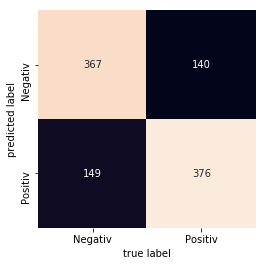

In [48]:
#Confusion matrix of model
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

labels = model.predict(X_test)
target_names = ['Negativ', 'Positiv']
mat = confusion_matrix(y_test, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()

In [49]:
from sklearn.model_selection import cross_val_score,  KFold

#kfold
kfold = KFold(n_splits=5)

#StratifiedKFold
#standard for cv=INT is stratified k-fold

scores = cross_val_score(pipeline, X_train, y_train, cv=5)
print("Cross-validation scores: {}".format(scores))
print("Mean accuracy: {}".format(scores.mean()))

Cross-validation scores: [0.75786925 0.69491525 0.7184466  0.69417476 0.7038835 ]
Mean accuracy: 0.7138578716001787


In [36]:
from sklearn.model_selection import cross_validate
res = cross_validate(pipeline, X_train, y_train, cv=5, return_train_score=True)

#make DataFrame of result for better Visualisation
res_df = pd.DataFrame(res)
display(res_df)

#Print Mean of all Scores
print("Mean times and scores:\n", res_df.mean())

,fit_time,score_time,test_score,train_score
0,0.910798,0.193535,0.857797,0.929776
1,1.087337,0.256694,0.857753,0.930087
2,1.234218,0.198464,0.865344,0.932916
3,0.899036,0.161094,0.855878,0.930779
4,0.925805,0.232259,0.854351,0.928948


Mean times and scores:
 fit_time       1.011439
score_time     0.208409
test_score     0.858225
train_score    0.930501
dtype: float64


### Untersuchung der Predictions

In [52]:
# Erstellung eines DataFrames mit den Spalten: X_test, y_test, prediction
predictions = model.predict(X_test)
df_prediction = pd.DataFrame({
    'X_test': X_test,
    'y_test': y_test,
    'prediction': predictions
})

# neue Spalte, die Values von Spalten y_test und prediction vergleicht
df_prediction['vergleich'] = df_prediction['y_test'] == df_prediction['prediction']

df_prediction.head()

,X_test,y_test,prediction,vergleich
13113,"['speed', 'shine', 'good', 'product', 'purchas...",positiv,positiv,True
3016,"['wheel', 'covers', 'ordered', 'properly', 'si...",negativ,positiv,False
10355,"['definitely', 'improvement', 'results', 'near...",negativ,negativ,True
10208,"['ordered', 'based', 'product', 'name', 'size'...",negativ,negativ,True
12661,"['price', 'best', 'option', 'simple', 'black',...",negativ,positiv,False


In [53]:
# Speichern der Zeilen mit unterschiedlichen Werten in den Spalten "y_test" und "prediction" in einem neuen DF 
# und setzt Index zurück 
df_false_predictions = df_prediction[df_prediction.vergleich == False].reset_index(drop = True)

df_false_predictions.head()

,X_test,y_test,prediction,vergleich
0,"['wheel', 'covers', 'ordered', 'properly', 'si...",negativ,positiv,False
1,"['price', 'best', 'option', 'simple', 'black',...",negativ,positiv,False
2,"['much', 'say', 'product', 'fits', '125a', '5a...",negativ,positiv,False
3,"['ice', 'scraper', 'well', 'designed', 'sturdy...",positiv,negativ,False
4,"['based', 'several', 'reviews', 'reputation', ...",negativ,positiv,False


In [54]:
# Erstellung einer CSV Datei mit den falsch predicteden Zeilen
df_false_predictions.to_csv("false_predictions.csv", sep=';',index=False)

In [64]:
# Ausgabe eines Reviews, das negativ ist aber positiv predicted wurde
predict_false_positiv = df_false_predictions[df_false_predictions['prediction'] == 'positiv']
predict_false_positiv['X_test'].iloc[0]

"['wheel', 'covers', 'ordered', 'properly', 'size', 'tires', 'fit', 'nice', 'snug', 'one', 'covers', 'blows', 'wheel', 'winds', 'happy', 'product', 'even', 'though', 'purchased', 'amazon']"

In [65]:
# Ausgabe eines Reviews, das positiv ist aber negativ predicted wurde
predict_false_negativ = df_false_predictions[df_false_predictions['prediction'] == 'negativ']
predict_false_negativ['X_test'].iloc[0]

"['ice', 'scraper', 'well', 'designed', 'sturdy', 'enough', 'chisel', 'ice', 'brush', 'away', 'large', 'amounts', 'snow', 'lot', 'ice', 'scrapers', 'chisels', 'brushes', 'opposite', 'ends', 'handle', 'makes', 'using', 'chisel', 'cumbersome', 'since', 'hold', 'device', 'brush', 'however', 'hopkins', 'ice', 'hammer', 'placed', 'chisel', 'brush', 'end', 'device', 'overall', 'satisfied']"